# Yuhua Sandbox

## Algorithm to Automate Novelty Scoring

### Import Packages

In [20]:
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from functools import reduce
import openpyxl
import xlsxwriter

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk import ngrams, FreqDist
from nltk.lm import NgramCounter
import string
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from spacy.lang.en.stop_words import STOP_WORDS

from collections import Counter
import itertools

from sklearn.metrics.pairwise import cosine_similarity

from scipy import spatial

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

from nltk.cluster.kmeans import KMeansClusterer

from scipy import stats
from scipy.stats import pearsonr
import pingouin as pg
import os
import importlib
import utilities
import seaborn as sns
%matplotlib inline

# load semspace

In [2]:
splist=['cbow_6_ukwac_subtitle','cbow_subtitle','glove_6B','TASA']

/Users/yyu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
utilities.stopwords_edited

['just',
 'they',
 'most',
 'thru',
 'whereby',
 "'ll",
 'seem',
 'everyone',
 'may',
 'twenty',
 'below',
 'up',
 'least',
 'along',
 'call',
 'across',
 'take',
 '‘ll',
 'anything',
 'us',
 'you',
 'doing',
 'toward',
 'although',
 'do',
 'because',
 'every',
 'should',
 'once',
 'thus',
 'she',
 'give',
 'make',
 'towards',
 'must',
 'an',
 'everywhere',
 'seeming',
 'first',
 'few',
 'last',
 'full',
 'formerly',
 'yourselves',
 'his',
 'ours',
 'those',
 'is',
 'who',
 'quite',
 'latterly',
 'though',
 'beforehand',
 'n‘t',
 'he',
 'whereupon',
 '’re',
 'had',
 'therefore',
 'latter',
 '‘d',
 'for',
 'from',
 'we',
 "'re",
 'either',
 'but',
 'never',
 'throughout',
 'again',
 'else',
 'elsewhere',
 'whereafter',
 'might',
 'there',
 'between',
 'our',
 'due',
 'really',
 'each',
 'so',
 'nevertheless',
 'whose',
 'whenever',
 'which',
 'mine',
 'its',
 'was',
 'been',
 'amongst',
 'two',
 'whom',
 'if',
 'four',
 'becoming',
 'bottom',
 '‘s',
 '’d',
 'well',
 'seems',
 'using',
 

# novelty

In [9]:
sd_df=pd.read_csv('/Users/yyu/Box Sync/ORG-SCHOOL-WCAS-PSYCHOLOGY-BEEMAN-LAB/COAT/scoring/junk/results_novelty.csv')

In [10]:
sd_df = sd_df.drop(sd_df.columns[0], axis=1)
sd_df.describe()

,id,novelty_1,novelty_2,SemDis_cbowukwacsubtitle_nf_m,SemDis_cbowsubtitle_nf_m,SemDis_cbowBNCwikiukwac_nf_m,SemDis_TASA_nf_m,SemDis_glove_nf_m,SemDis_MEAN,SemDis_factor,...,ewm_cbow_6_ukwac_subtitle,min_cbow_6_ukwac_subtitle,ewm_cbow_subtitle,min_cbow_subtitle,ewm_glove_6B,min_glove_6B,ewm_TASA,min_TASA,ewm_MEAN,min_MEAN
count,3403.000000,3.403000e+03,3.403000e+03,3.403000e+03,3.403000e+03,3.403000e+03,3.403000e+03,3.403000e+03,3.403000e+03,3.403000e+03,...,3.390000e+03,3.390000e+03,3.390000e+03,3.390000e+03,3.390000e+03,3.390000e+03,3.390000e+03,3.390000e+03,3.390000e+03,3.390000e+03
mean,1365.301205,6.767532e-16,6.408822e-16,-1.256056e-17,-4.014486e-17,-6.929514e-17,-1.660604e-17,2.751905e-16,-1.735641e-16,5.583309e-08,...,4.480192e-17,3.473786e-16,5.063960e-17,2.780552e-16,-1.429044e-16,-3.416228e-17,2.716935e-16,4.945241e-16,-3.946327e-16,4.603905e-16
std,165.415553,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.371654e-01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1087.000000,-1.262926e+00,-1.359929e+00,-2.808355e+00,-3.748207e+00,-4.266378e+00,-4.253843e+00,-2.804969e+00,-3.437214e+00,-5.576800e-01,...,-2.461377e+00,-2.649615e+00,-3.224401e+00,-3.272763e+00,-2.687792e+00,-3.371983e+00,-3.766319e+00,-3.609214e+00,-2.881238e+00,-2.891382e+00
25%,1194.000000,-1.262926e+00,-4.187374e-01,-6.234063e-01,-4.039869e-01,-3.848791e-01,-2.571511e-01,-7.489164e-01,-3.697861e-01,-6.854000e-02,...,-6.091928e-01,-5.884959e-01,-5.039085e-01,-5.213021e-01,-7.496201e-01,-6.653668e-01,-2.213159e-01,-2.968628e-01,-5.085432e-01,-5.600961e-01
50%,1402.000000,-3.432306e-01,5.224538e-01,2.419702e-01,2.276574e-01,2.481962e-01,2.421779e-01,6.413200e-02,3.050227e-01,4.060000e-02,...,1.302011e-01,1.762191e-01,2.175154e-01,2.277468e-01,-3.081573e-02,9.135671e-02,2.911200e-01,3.088384e-01,2.237219e-01,2.970045e-01
75%,1511.000000,5.764652e-01,5.224538e-01,7.483109e-01,6.745049e-01,6.508839e-01,5.801807e-01,7.789335e-01,7.329696e-01,9.845500e-02,...,7.968346e-01,7.190518e-01,7.095631e-01,7.451656e-01,7.811721e-01,7.383517e-01,6.096429e-01,6.607935e-01,7.898023e-01,7.290640e-01
max,1622.000000,2.415857e+00,2.404836e+00,2.012365e+00,2.099050e+00,2.576347e+00,2.475961e+00,2.261528e+00,1.569289e+00,2.503900e-01,...,2.042444e+00,2.232130e+00,2.131302e+00,1.935276e+00,2.594485e+00,2.983109e+00,1.590963e+00,1.602763e+00,1.647630e+00,2.002532e+00


In [12]:
sd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3403 entries, 0 to 3402
Data columns (total 26 columns):
id                               3403 non-null int64
novelty_1                        3403 non-null float64
novelty_2                        3403 non-null float64
response                         3403 non-null object
response_nofill                  3403 non-null object
item                             3403 non-null object
item_nofill                      3403 non-null object
SemDis_cbowukwacsubtitle_nf_m    3403 non-null float64
SemDis_cbowsubtitle_nf_m         3403 non-null float64
SemDis_cbowBNCwikiukwac_nf_m     3403 non-null float64
SemDis_TASA_nf_m                 3403 non-null float64
SemDis_glove_nf_m                3403 non-null float64
SemDis_MEAN                      3403 non-null float64
SemDis_factor                    3403 non-null float64
novelty_m                        3403 non-null float64
response_processed               3403 non-null object
ewm_cbow_6_ukwac_sub

In [65]:
splist

['cbow_6_ukwac_subtitle', 'cbow_subtitle', 'glove_6B', 'TASA']

In [68]:
metrics=['SemDis_cbowukwacsubtitle_nf_m','SemDis_cbowsubtitle_nf_m','SemDis_cbowBNCwikiukwac_nf_m',
        'SemDis_TASA_nf_m','SemDis_glove_nf_m']+['ewm_'+sp for sp in splist]+['min_'+sp for sp in splist]
metrics=['ewm_'+sp for sp in splist]+['min_'+sp for sp in splist] +['SemDis_cbowukwacsubtitle_nf_m','SemDis_cbowsubtitle_nf_m',
        'SemDis_glove_nf_m','SemDis_TASA_nf_m','SemDis_cbowBNCwikiukwac_nf_m']
corrdf=sd_df[metrics].corr()

(13.0, 0.0)

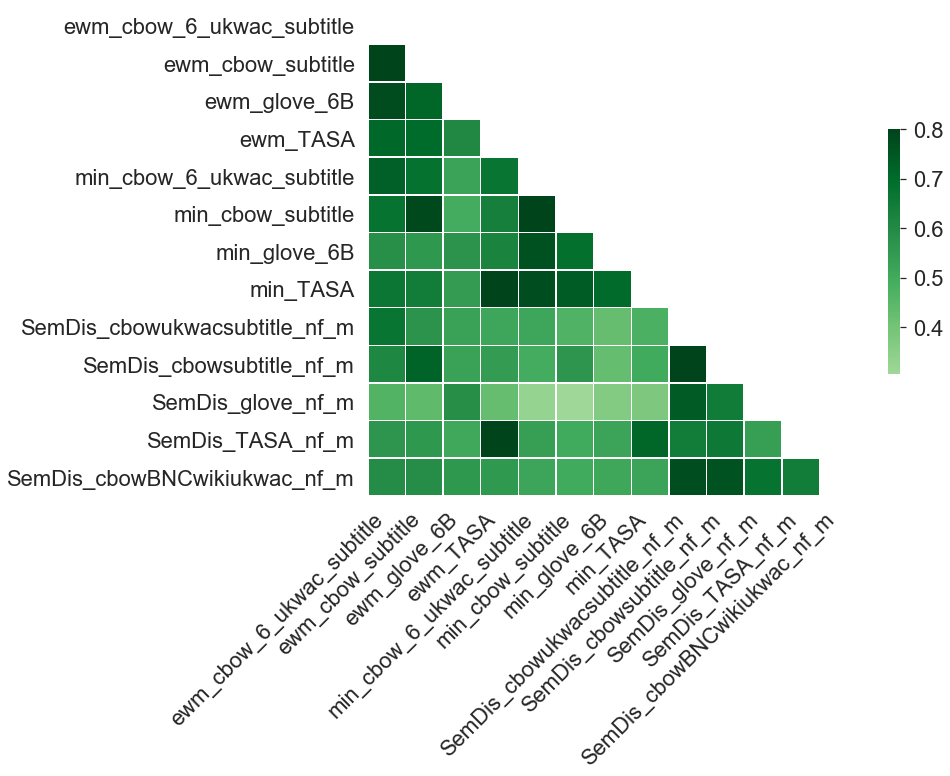

In [70]:
sns.set(font_scale=2) 
sns.set_style("whitegrid")
mask = np.triu(np.ones_like(corrdf, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 304, s=80,sep=20,center='light',as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrdf, mask=mask, cmap='Greens',center=.4,vmax=.8,
            square=True, linewidths=.5,cbar_kws={"shrink": .5})
plt.xticks(rotation=45,horizontalalignment='right')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

(4.0, 0.0)

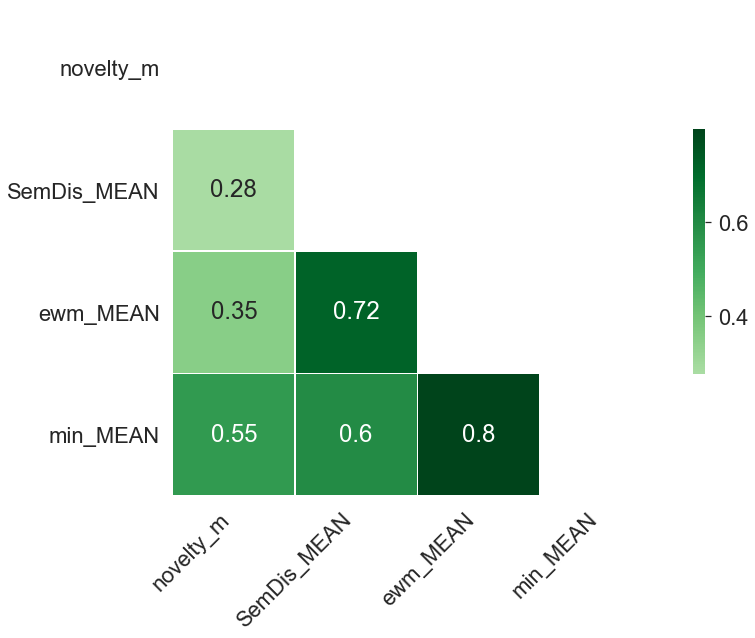

In [64]:
metrics=['novelty_m','SemDis_MEAN','ewm_MEAN','min_MEAN']
corrdf=sd_df[metrics].corr()
sns.set(font_scale=2) 
sns.set_style("whitegrid")
mask = np.triu(np.ones_like(corrdf, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 304, s=80,sep=20,center='light',as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrdf, mask=mask, cmap='Greens',center=.4,
            square=True, linewidths=.5,cbar_kws={"shrink": .5},annot=True)
plt.xticks(rotation=45,horizontalalignment='right')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

# Originality

In [ ]:
importlib.reload(utilities)

In [72]:
orig_df = pd.read_csv('/Users/yyu/Box Sync/ORG-SCHOOL-WCAS-PSYCHOLOGY-BEEMAN-LAB/COAT/scoring/junk/results_originality.csv')
orig_df = orig_df.drop(orig_df.columns[0], axis=1)
orig_df.head()

,item,response_processed,response,originality_cbow_6_ukwac_subtitle,originality_cbow_subtitle,originality_glove_6B,originality_TASA,originality_mean
0,Box,['store'],to store things,-1.172966,-1.205269,-0.404760,-1.683041,-1.329260
1,Box,"['build', 'fort']",to build a fort,-0.099436,0.159921,0.530575,0.071028,0.175593
2,Box,['umbrella'],as an umbrella,-0.866243,0.008233,1.232077,-0.566815,-0.113302
3,Box,"['catch', 'bunny']",to catch a bunny,1.127456,1.070048,1.348994,0.071028,1.011418
4,Box,['standing'],standing on,0.360648,0.311609,0.881326,-0.566815,0.244125


In [73]:
orig_df.columns

Index(['item', 'response_processed', 'response',
       'originality_cbow_6_ukwac_subtitle', 'originality_cbow_subtitle',
       'originality_glove_6B', 'originality_TASA', 'originality_mean'],
      dtype='object')

In [ ]:
origina

In [78]:

sdColumns=['SemDis_cbowukwacsubtitle_nf_m','SemDis_cbowsubtitle_nf_m',
        'SemDis_glove_nf_m','SemDis_TASA_nf_m','SemDis_cbowBNCwikiukwac_nf_m']
algoColumns=['ewm_'+sp for sp in splist]+['min_'+sp for sp in splist]
origColumns=['originality_'+sp for sp in splist]
meanColumns=['novelty_m','SemDis_MEAN','ewm_MEAN','min_MEAN']

In [77]:
orig_df[sdColumns+algoColumns+meanColumns]=sd_df[sdColumns+algoColumns+meanColumns]

In [83]:
orig_df.rename(columns=dict([(x,x[:-5]) for x in sdColumns]),inplace=True)

In [85]:
sdColumns=['SemDis_cbowukwacsubtitle','SemDis_cbowsubtitle',
        'SemDis_glove','SemDis_TASA','SemDis_cbowBNCwikiukwac']

(4.0, 0.0)

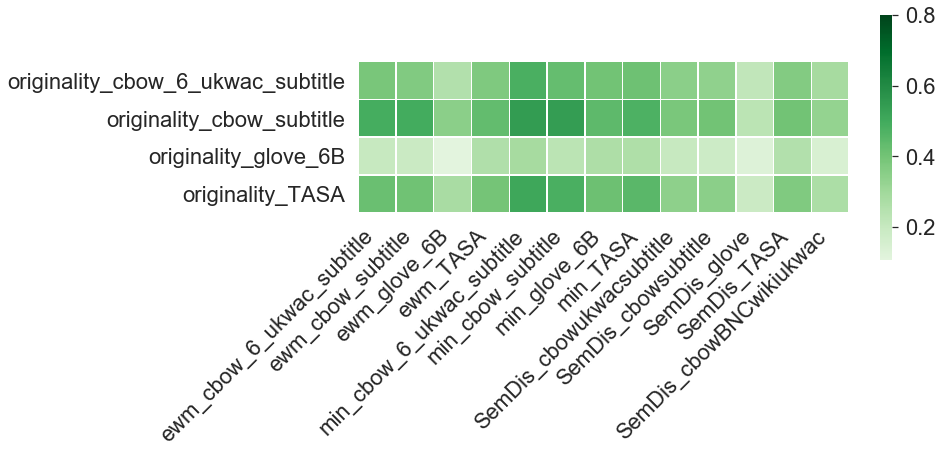

In [86]:
tmp=orig_df.corr().loc[origColumns,algoColumns+sdColumns]
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 304, s=80,sep=20,center='light',as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(tmp, cmap='Greens',center=.4,vmax=.8,
            square=True, linewidths=.5,cbar_kws={"shrink": .5})
plt.xticks(rotation=45,horizontalalignment='right')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

(5.0, 0.0)

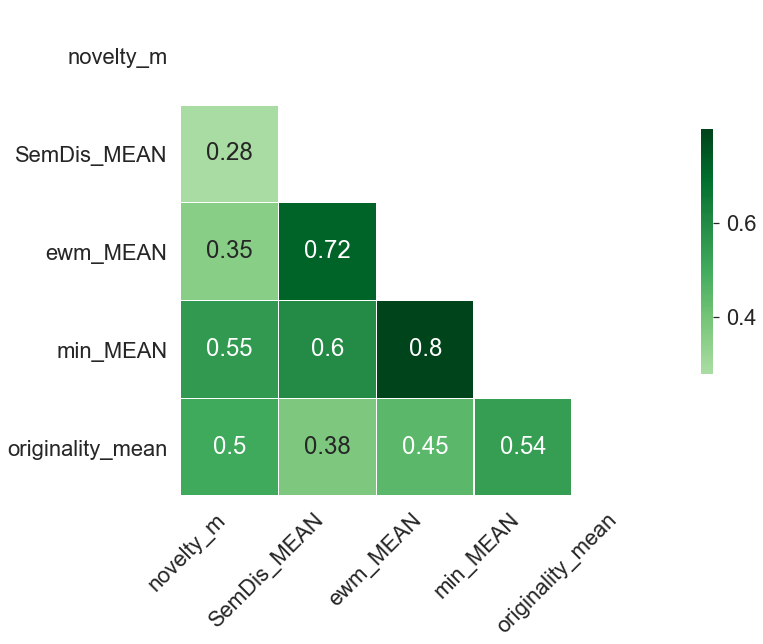

In [87]:
metrics=['novelty_m','SemDis_MEAN','ewm_MEAN','min_MEAN','originality_mean']
corrdf=orig_df[metrics].corr()
sns.set(font_scale=2) 
sns.set_style("whitegrid")
mask = np.triu(np.ones_like(corrdf, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 304, s=80,sep=20,center='light',as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrdf, mask=mask, cmap='Greens',center=.4,
            square=True, linewidths=.5,cbar_kws={"shrink": .5},annot=True)
plt.xticks(rotation=45,horizontalalignment='right')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

# Flexibility/diversity

In [103]:
disp_df=pd.read_csv('/Users/yyu/Box Sync/ORG-SCHOOL-WCAS-PSYCHOLOGY-BEEMAN-LAB/COAT/scoring/junk/results_dispersion.csv')
disp_df = disp_df.drop(disp_df.columns[0], axis=1)
disp_df.head()

,id,item,dispMax_cbow_6_ukwac_subtitle,dispVar_cbow_6_ukwac_subtitle,dispMax_cbow_subtitle,dispVar_cbow_subtitle,dispMax_glove_6B,dispVar_glove_6B,dispMax_TASA,dispVar_TASA,...,originality_TASA,originality_mean,SemDis_MEAN,ewm_MEAN,min_MEAN,novelty_m,nCat,dispMax_m,dispVar_m,fluency
0,1087,Box,0.511133,0.450911,0.498620,0.474570,0.721733,0.576914,0.547451,0.504865,...,-0.208028,-0.225996,0.225828,0.495915,0.818186,1.877289,0.875007,0.569734,0.173635,-0.394058
1,1087,Brick,0.703763,0.580512,0.610198,0.566628,0.749936,0.608155,0.662801,0.580500,...,0.008535,-0.497605,-0.287907,0.195613,0.612576,1.189987,0.875007,0.681675,0.942098,0.688469
2,1087,Chair,0.643097,0.557730,0.663514,0.569337,0.961296,0.655672,0.644059,0.578499,...,0.071656,0.255033,0.114499,0.524615,0.415744,0.502685,2.052079,0.727991,1.001608,0.688469
3,1087,Cup,0.578858,0.469661,0.684959,0.572062,0.621046,0.544855,0.648116,0.606493,...,-0.441108,-0.532123,1.011456,-0.046581,0.014840,0.330860,0.875007,0.633245,0.608255,0.688469
4,1087,Key,0.489473,0.420228,0.470354,0.438570,0.627107,0.336656,0.588258,0.512673,...,-0.143304,-0.398242,1.452195,1.809888,0.786952,0.073122,-0.302066,0.543798,-0.526055,-0.394058


In [107]:
disp_df.columns

Index(['id', 'item', 'dispMax_cbow_6_ukwac_subtitle',
       'dispers_cbow_6_ukwac_subtitle', 'dispMax_cbow_subtitle',
       'dispers_cbow_subtitle', 'dispMax_glove_6B', 'dispers_glove_6B',
       'dispMax_TASA', 'dispers_TASA', 'originality_cbow_6_ukwac_subtitle',
       'originality_cbow_subtitle', 'originality_glove_6B', 'originality_TASA',
       'originality_mean', 'SemDis_MEAN', 'ewm_MEAN', 'min_MEAN', 'novelty_m',
       'nCat', 'dispMax_m', 'dispers_MEAN', 'fluency'],
      dtype='object')

In [105]:
disp_df.rename(columns=dict([('dispVar_'+sp,'dispers_'+sp) for sp in splist]),inplace=True)
disp_df.rename(columns={'dispVar_m':'dispers_MEAN'},inplace=True)

(8.0, 0.0)

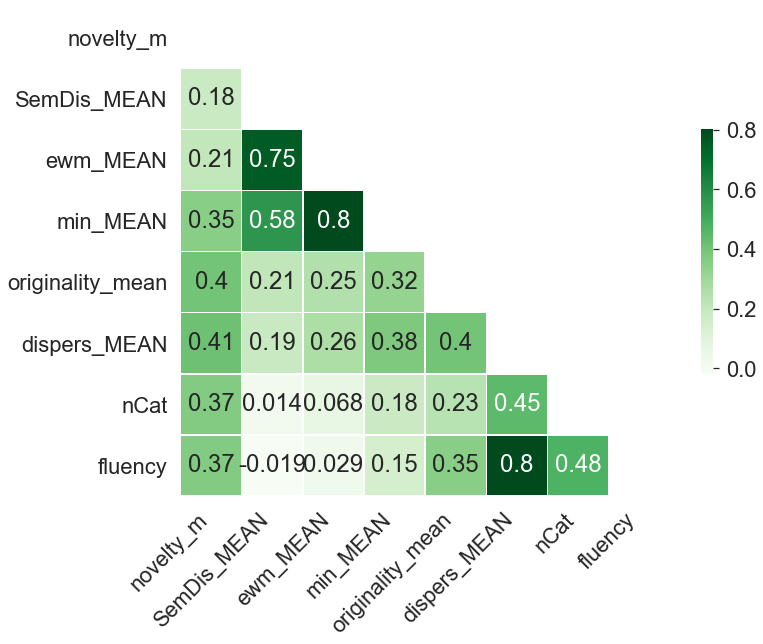

In [110]:
metrics=['novelty_m','SemDis_MEAN','ewm_MEAN','min_MEAN','originality_mean','dispers_MEAN','nCat','fluency']
corrdf=disp_df[metrics].corr()
sns.set(font_scale=2) 
sns.set_style("whitegrid")
mask = np.triu(np.ones_like(corrdf, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 304, s=80,sep=20,center='light',as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrdf, mask=mask, cmap='Greens',center=.4,
            square=True, linewidths=.5,cbar_kws={"shrink": .5},annot=True)
plt.xticks(rotation=45,horizontalalignment='right')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

# All together

In [111]:
disp_df[disp_df['id']==1118][['item','fluency']]

,item,fluency
40,Box,-0.394058
41,Brick,0.147206
42,Chair,-0.394058
43,Cup,0.147206
44,Key,-0.935322
45,Pencil,0.688469
46,Rope,-0.394058
47,Shoe,-0.935322


In [204]:
columnnames=['id','item','fluency']
disp_df=disp_df.merge(pd.DataFrame(alldata,columns=columnnames),left_on=['id','item'],right_on=['id','item'])
disp_df.head()

,id,item,dispMax_cbow_6_ukwac_subtitle,dispVar_cbow_6_ukwac_subtitle,dispMax_cbow_subtitle,dispVar_cbow_subtitle,dispMax_glove_6B,dispVar_glove_6B,dispMax_TASA,dispVar_TASA,...,originality_TASA,originality_mean,SemDis_MEAN,ewm_MEAN,min_MEAN,novelty_m,nCat,dispMax_m,dispVar_m,fluency
0,1087,Box,0.511133,0.450911,0.498620,0.474570,0.721733,0.576914,0.547451,0.504865,...,-0.208028,-0.177131,0.139193,0.279498,0.398051,0.833859,3,0.569734,0.501815,4
1,1087,Brick,0.703763,0.580512,0.610198,0.566628,0.749936,0.608155,0.662801,0.580500,...,0.008535,-0.309219,-0.168545,0.106239,0.290484,0.503336,3,0.681675,0.583949,6
2,1087,Chair,0.643097,0.557730,0.663514,0.569337,0.961296,0.655672,0.644059,0.578499,...,0.071656,0.056802,0.072505,0.296057,0.187510,0.172813,4,0.727991,0.590310,6
3,1087,Cup,0.578858,0.469661,0.684959,0.572062,0.621046,0.544855,0.648116,0.606493,...,-0.441108,-0.326006,0.609803,-0.033496,-0.022227,0.090182,3,0.633245,0.548268,6
4,1087,Key,0.489473,0.420228,0.470354,0.438570,0.627107,0.336656,0.588258,0.512673,...,-0.143304,-0.260897,0.873816,1.037597,0.381711,-0.033764,2,0.543798,0.427032,4


In [209]:
metrics

['originality_cbow_6_ukwac_subtitle',
 'originality_cbow_subtitle',
 'originality_glove_6B',
 'originality_TASA',
 'originality_mean']

In [112]:
metrics_agg=['originality_mean','dispers_MEAN','ewm_MEAN','min_MEAN','SemDis_MEAN','novelty_m','nCat','fluency']

In [215]:
disp_df.corr().loc[metrics_agg,metrics_agg]

,originality_mean,dispVar_m,dispMax_m,ewm_MEAN,min_MEAN,SemDis_MEAN,novelty_m,nCat,fluency
originality_mean,1.000000,0.403020,0.356919,0.247846,0.323411,0.212182,0.402108,0.234664,0.354246
dispVar_m,0.403020,1.000000,0.951903,0.263974,0.377659,0.190687,0.412886,0.448170,0.801172
dispMax_m,0.356919,0.951903,1.000000,0.212066,0.308641,0.156406,0.349431,0.420803,0.790111
ewm_MEAN,0.247846,0.263974,0.212066,1.000000,0.800295,0.753595,0.207636,0.068182,0.029408
min_MEAN,0.323411,0.377659,0.308641,0.800295,1.000000,0.576208,0.354804,0.182189,0.146908
SemDis_MEAN,0.212182,0.190687,0.156406,0.753595,0.576208,1.000000,0.184146,0.013711,-0.018865
novelty_m,0.402108,0.412886,0.349431,0.207636,0.354804,0.184146,1.000000,0.365824,0.366436
nCat,0.234664,0.448170,0.420803,0.068182,0.182189,0.013711,0.365824,1.000000,0.475198
fluency,0.354246,0.801172,0.790111,0.029408,0.146908,-0.018865,0.366436,0.475198,1.000000


In [217]:
disp_df.columns

Index(['id', 'item', 'dispMax_cbow_6_ukwac_subtitle',
       'dispVar_cbow_6_ukwac_subtitle', 'dispMax_cbow_subtitle',
       'dispVar_cbow_subtitle', 'dispMax_glove_6B', 'dispVar_glove_6B',
       'dispMax_TASA', 'dispVar_TASA', 'originality_cbow_6_ukwac_subtitle',
       'originality_cbow_subtitle', 'originality_glove_6B', 'originality_TASA',
       'originality_mean', 'SemDis_MEAN', 'ewm_MEAN', 'min_MEAN', 'novelty_m',
       'nCat', 'dispMax_m', 'dispVar_m', 'fluency'],
      dtype='object')

In [113]:
icc_df=pd.DataFrame()
for col in metrics_agg:
    icc = pg.intraclass_corr(data=disp_df, targets='id', raters='item', ratings=col,nan_policy='omit')
    icc_df=pd.concat([icc_df,pd.DataFrame(icc.set_index('Type').loc['ICC3k']).T])
icc_df['metrics']=metrics_agg
icc_df=icc_df.drop(labels=['Description'],axis=1).set_index('metrics')
icc_df

,ICC,F,df1,df2,pval,CI95%
metrics,,,,,,
originality_mean,0.678638,3.11175,86,602,6.07483e-16,"[0.57, 0.77]"
dispers_MEAN,0.81883,5.51967,86,602,2.19727e-37,"[0.76, 0.87]"
ewm_MEAN,0.620263,2.6334,86,602,9.86528e-12,"[0.49, 0.73]"
min_MEAN,0.652427,2.87709,86,602,7.36044e-14,"[0.53, 0.75]"
SemDis_MEAN,0.748543,3.97682,86,602,9.77235e-24,"[0.66, 0.82]"
novelty_m,0.741256,3.86482,86,602,1.00146e-22,"[0.65, 0.82]"
nCat,0.693643,3.26416,86,602,2.62065e-17,"[0.59, 0.78]"
fluency,0.871303,7.77018,86,602,8.48901e-56,"[0.83, 0.91]"


In [114]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo


In [115]:
metrics_agg

['originality_mean',
 'dispers_MEAN',
 'ewm_MEAN',
 'min_MEAN',
 'SemDis_MEAN',
 'novelty_m',
 'nCat',
 'fluency']

In [116]:
disp_df[metrics_agg]=(disp_df[metrics_agg]-disp_df[metrics_agg].mean())/disp_df[metrics_agg].std()

In [117]:
kmo_all,kmo_model=calculate_kmo(disp_df[metrics_agg])

In [118]:
kmo_model #this value is [0,1], less than .6 means FA is inadequent 

0.7207516715077896

In [119]:
fa = FactorAnalyzer(n_factors=3)
fa.fit(disp_df[metrics_agg])
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev #only need those EV greater than 1

array([3.33956033, 1.95652413, 0.7734821 , 0.69236373, 0.53682072,
       0.39821783, 0.1643784 , 0.13865274])

In [261]:
fa = FactorAnalyzer(n_factors=4)
fa.fit(disp_df[metrics_agg])
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev #only need those EV greater than 1

array([3.33956033, 1.95652413, 0.7734821 , 0.69236373, 0.53682072,
       0.39821783, 0.1643784 , 0.13865274])

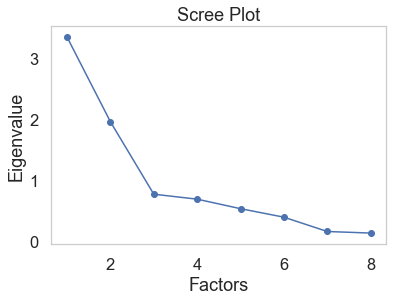

In [122]:
sns.set(font_scale=1.5) 
sns.set_style("whitegrid")
plt.scatter(range(1,disp_df[metrics_agg].shape[1]+1),ev)
plt.plot(range(1,disp_df[metrics_agg].shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

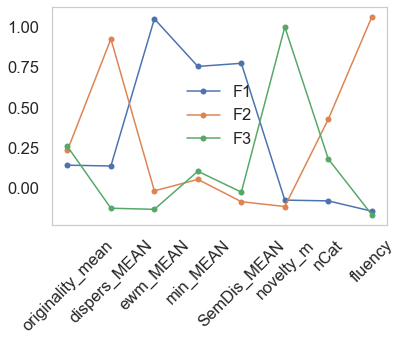

In [123]:
sns.set(font_scale=1.5) 
sns.set_style("whitegrid")
plt.plot(fa.loadings_,marker='o')
plt.grid()
plt.legend(['F1','F2','F3'])
plt.xticks(ticks=range(len(metrics_agg)),labels=metrics_agg,rotation=45)
plt.show()

In [267]:
fa.get_factor_variance()

(array([2.3468864 , 2.24798115, 1.17238102]),
 array([0.2933608 , 0.28099764, 0.14654763]),
 array([0.2933608 , 0.57435844, 0.72090607]))

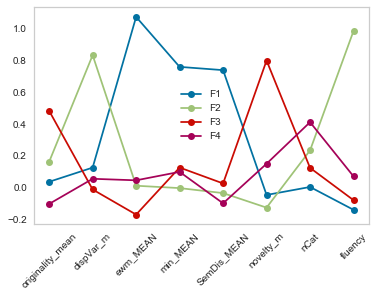

In [262]:
plt.plot(fa.loadings_,marker='o')
plt.grid()
plt.legend(['F1','F2','F3','F4'])
plt.xticks(ticks=range(len(metrics_agg)),labels=metrics_agg,rotation=45)
plt.show()